#DevPlan
  1. Pré-processamento dos dados

    1.1. Baixar dataset
    1.2. Organizar imagens em labels (Câncer do endométrio = 1; Não cancerígeno = 0)
    1.3. Aplicar Augmentations contidos no dicionário aletoriamente com igual propabilidade pelo dataset. Fazendo 2 novas imagens por cada imagem já existente no dataset.
    1.4. Converter imagens para os oito esquemas de cores a serem analisados
    ["RGB", "LUV", "Grayscale", "XYZ", "HLS", "YCrCb", "HSV", "LAB"]

  2. Extração de características
    
    2.1. Aplicação da técnica Radiomics para extração de características das imagens
    Categorias e quantidades de características extraídas no artigo foram:
    {"First Order": 16,
    "Gray Level Co-occurrence Matrix (GLCM)": 24,
    "Gray Level Dependence Matrix (GLDM)": 14,
    "Gray Level Run Length Matrix (GLRLM)": 16,
    "Gray Level Size Zone Matrix (GLSZM)": 16,
    "Neighboring Gray Tone Difference Matrix (NGTDM)": 5}

    2.2. Aplicar I-RFE para seleção das principais características para classificação do câncer de ovário.
    2.3. Artigo citado utilizou SVM
    2.4. Utilizar o F1-score para determinar o ponto ideal de eliminação das características.
    Caso o valor piore, a eliminação de características deve ser interrompida.

  3. Classificação

    3.1. Validação cruzada.
    3.2. Aplicação de algoritmos de aprendizagem de máquina:
    ["SVM",
    "RF",
    "KNN",
    "XGB",
    "ADA"].
    Fazer isso para todos os 8 esquemas de cores.

  4. Avaliação dos resultados

    4.1. Avaliação do resultado com as métricas:
    ["Acurácia[ACC]",
    "Especificidade[ESP]",
    "Sensibilidade[SEN]",
    "Precisão[PRE]",
    "F1-Score",
    "Kappa",
    "AUC-ROC"]
    4.2. Plot da matriz de confusão

  5. Experimentos

    Utilizar validação cruzada com k-fold = 5 e os hiperparâmetros padrões da biblioteca scikit-learn.

    5.1. Experimento 1:
    Radiomics
    RGB
    Sem I-RFE
    Todos os classificadores

    5.2. Experimento 2:
    Radiomics
    Todos os esquemas de cores
    Sem I-RFE
    Todos os classificadores
    Printar tabela com o melhor classificador de cada esquema de cor

    5.3. Experimento 3:
    Radiomics
    Todos os esquemas de cores
    Com I-RFE
    Todos os classificadores
    Printar tabela com o melhor classificador de cada esquema de cor

  6. Explicabilidade

    6.1. Plot SHAP para identificar principais features

# 1. Pré-processamento dos dados

In [ ]:
# 1.1. Baixar dataset
import kagglehub

download_path = kagglehub.dataset_download("bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology")

Using Colab cache for faster access to the 'ovarian-cancer-and-subtypes-dataset-histopathology' dataset.


In [ ]:
#Caminhos apenas as subpastas interessadas (Endometrio e Não cancerígeno)
import os

contentsPath = os.listdir(download_path) #/OvarianCancer
contentsPath = os.path.join(download_path, 'OvarianCancer') #bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer

endometriPath = os.path.join(contentsPath, 'Endometri') #bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer/Endometri
nonCancerousPath = os.path.join(contentsPath, 'Non_Cancerous') #bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer/Non_Cancerous

In [ ]:
# 1.2. Organizar imagens em labels
#Salvando o caminho das images no array (98 imagens de endometrio, 100 não cancerígenas)
label = []
imgPathsEndometri = []
for imgName in os.listdir(endometriPath): #Não garante ordem dos arquivos
    if imgName.lower().endswith(".jpg"):
        imgPath = os.path.join(endometriPath, imgName)
        imgPathsEndometri.append(imgPath)
        label.append("Positivo")

imgPathsNonCancerous = []
for imgName in os.listdir(nonCancerousPath): #Não garante ordem dos arquivos
    if imgName.lower().endswith(".jpg"):
        imgPath = os.path.join(nonCancerousPath, imgName)
        imgPathsNonCancerous.append(imgPath)
        label.append("Negativo")

#Total de caminhos
imgPathsTotal = imgPathsEndometri + imgPathsNonCancerous

In [ ]:
#Instalando pyRadiomics e dependências
!pip install git+https://github.com/AIM-Harvard/pyradiomics.git

  Cloning https://github.com/AIM-Harvard/pyradiomics.git to /tmp/pip-req-build-k9dai4vo
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyradiomics.git /tmp/pip-req-build-k9dai4vo
  Resolved https://github.com/AIM-Harvard/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 42.6 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g8ed579383-cp312-cp312-linux_x86_64.whl size=121811 sha256=d8e40121360ec5d33fd760a82e4ed9314be5159bb472c3600719268eb40ba19d
  Stored in directory: 

In [ ]:
import albumentations as A

# Dicionário com 10 augmentations moderadas
augmentations_dict = {
    "rotate": A.Rotate(limit=30, p=0.5),                # Rotação leve (-30° a +30°)
    "flip_horizontal": A.HorizontalFlip(p=0.5),         # Espelhamento horizontal
    "flip_vertical": A.VerticalFlip(p=0.5),             # Espelhamento vertical
    "shift_scale": A.ShiftScaleRotate(shift_limit=0.1,
                                      scale_limit=0.1,
                                      rotate_limit=0, p=0.5),  # Pequeno deslocamento/escala
    "brightness": A.RandomBrightnessContrast(brightness_limit=0.2,
                                             contrast_limit=0.2, p=0.5), # Brilho/contraste leve
    "blur": A.GaussianBlur(blur_limit=(3, 5), p=0.5),   # Desfoque gaussiano leve
    "noise": A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), # Ruído gaussiano moderado
    "hue_saturation": A.HueSaturationValue(hue_shift_limit=10,
                                           sat_shift_limit=20,
                                           val_shift_limit=10, p=0.5), # Pequena variação de cor
    "crop": A.RandomResizedCrop(size=(224, 224),
                                scale=(0.9, 1.0), p=0.5), # Crop leve
    "elastic": A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.5) # Deformação leve
}

# Pipeline que aplica 1 augmentation aleatória por imagem
augmentation_pipeline = A.OneOf(
    list(augmentations_dict.values()),
    p=1.0
)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-516670643.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  "noise": A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), # Ruído gaussiano moderado
/tmp/ipython-input-516670643.py:20: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  "elastic": A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.5) # Deformação leve


In [ ]:
#Geração de imagens
import cv2
import os

augmented_images_data = []

for i, img_path in enumerate(imgPathsTotal):
    # Carrega imagem original
    original_image = cv2.imread(img_path)
    if original_image is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        continue

    # label
    original_label = "Positivo" if img_path in imgPathsEndometri else "Negativo"

    # Generate 2 augmented images
    for k in range(2):
        augmented_image = augment_image(original_image)

        # Salvando em memória
        augmented_images_data.append({
            "original_path": img_path,
            "label": original_label,
            "augmented_image_data": augmented_image, # NumPy array of the image
            "augmentation_index": k + 1
        })

print(f"Generated {len(augmented_images_data)} augmented images.")
print(f"Example of stored data for one augmented image: {list(augmented_images_data[0].keys())}")

Generated 396 augmented images.
Example of stored data for one augmented image: ['original_path', 'label', 'augmented_image_data', 'augmentation_index']


In [ ]:
import uuid

unified_dataset = []

# Add original images to unified_dataset
for img_path in imgPathsTotal:
    label_value = "Positivo" if img_path in imgPathsEndometri else "Negativo"
    unified_dataset.append({
        "identifier": img_path,
        "image_data": img_path,
        "label": label_value,
        "is_augmented": False
    })

# Add augmented images to unified_dataset
for augmented_entry in augmented_images_data:
    # Generate a unique identifier for augmented images
    unique_id = f"{augmented_entry['original_path']}_aug_{augmented_entry['augmentation_index']}_{uuid.uuid4().hex}"
    unified_dataset.append({
        "identifier": unique_id,
        "image_data": augmented_entry["augmented_image_data"],
        "label": augmented_entry["label"],
        "is_augmented": True
    })

print(f"Total entries in unified_dataset: {len(unified_dataset)}")
print("Example original image entry:")
print(unified_dataset[0])
print("Example augmented image entry:")
# Find the first augmented image entry to print as example
first_augmented_entry = next((entry for entry in unified_dataset if entry['is_augmented']), None)
if first_augmented_entry:
    # To avoid printing a large numpy array, print its shape and type instead
    example_aug_data = first_augmented_entry.copy()
    example_aug_data['image_data_shape'] = example_aug_data['image_data'].shape
    example_aug_data['image_data_dtype'] = str(example_aug_data['image_data'].dtype)
    del example_aug_data['image_data']
    print(example_aug_data)
else:
    print("No augmented images found.")


Total entries in unified_dataset: 594
Example original image entry:
{'identifier': '/kaggle/input/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer/Endometri/image_edo_0_3097.jpg', 'image_data': '/kaggle/input/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer/Endometri/image_edo_0_3097.jpg', 'label': 'Positivo', 'is_augmented': False}
Example augmented image entry:
{'identifier': '/kaggle/input/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer/Endometri/image_edo_0_3097.jpg_aug_1_386b0658ddfe437697a0e4663c5d0f2a', 'label': 'Positivo', 'is_augmented': True, 'image_data_shape': (459, 613, 3), 'image_data_dtype': 'uint8'}


In [ ]:
import pandas as pd
import SimpleITK as sitk
import numpy as np
from PIL import Image
from radiomics import featureextractor
import cv2

results = []

def extract_features_from_image(image_input, color_mode, label):
    imgBgr = None
    if isinstance(image_input, str):

        imgBgr = cv2.imread(image_input)
    elif isinstance(image_input, np.ndarray):

        imgBgr = image_input
    else:
        raise ValueError("image_input must be a file path (str) or a NumPy array.")

    if imgBgr is None:
        print(f"Warning: Could not read image from {image_input}. Skipping feature extraction.")
        return

    match color_mode:
      case "Grayscale":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2GRAY)
      case "RGB":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2RGB)
      case "LUV":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2LUV)
      case "XYZ":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2XYZ)
      case "LAB":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2LAB)
      case "YCrCb":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2YCrCb)
      case "HLS":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2HLS)
      case "HSV":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2HSV)

    img_np = np.array(img, dtype=np.float32)

    if color_mode == "Grayscale":
        channels = {"Gray": img_np}
    else:
        channels = {
            "firstChannel": img_np[:, :, 0],
            "secondChannel": img_np[:, :, 1],
            "thirdChannel": img_np[:, :, 2],
        }

    for channel_name, channel_data in channels.items():
        image = sitk.GetImageFromArray(channel_data)

        mask_arr = np.ones(channel_data.shape, dtype=np.uint8)
        mask_sitk = sitk.GetImageFromArray(mask_arr)
        mask_sitk.CopyInformation(image)

        features = extractor.execute(image, mask_sitk)

        feature_record = {
            "image_name": "original_image" if isinstance(image_input, str) else "augmented_image", # Placeholder name
            "color_mode": color_mode,
            "channel": channel_name,
            "label": label
        }
        if isinstance(image_input, str):
            feature_record["image_name"] = os.path.basename(image_input)
        else:

            pass

        for featureName, value in features.items():
            feature_record[featureName] = value

        results.append(feature_record)


color_modes = ["RGB", "LUV", "Grayscale", "XYZ", "HLS", "YCrCb", "HSV", "LAB"]



In [ ]:
#Extração de características
import pandas as pd
import SimpleITK as sitk
import numpy as np
from PIL import Image
from radiomics import featureextractor
import cv2
import os

results = []

def extract_features_from_image(image_input, color_mode, label, image_identifier):
    imgBgr = None
    if isinstance(image_input, str):
        # It's a path, read the image
        imgBgr = cv2.imread(image_input)
    elif isinstance(image_input, np.ndarray):
        # It's already a NumPy array
        imgBgr = image_input
    else:
        raise ValueError("image_input must be a file path (str) or a NumPy array.")

    if imgBgr is None:
        print(f"Warning: Could not read image from {image_identifier}. Skipping feature extraction.")
        return

    # Ensure the image has 3 channels for color conversion if it's grayscale
    if len(imgBgr.shape) == 2:
        imgBgr = cv2.cvtColor(imgBgr, cv2.COLOR_GRAY2BGR)

    match color_mode:
      case "Grayscale":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2GRAY)
      case "RGB":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2RGB)
      case "LUV":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2LUV)
      case "XYZ":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2XYZ)
      case "LAB":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2LAB)
      case "YCrCb":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2YCrCb)
      case "HLS":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2HLS)
      case "HSV":
          img = cv2.cvtColor(imgBgr, cv2.COLOR_BGR2HSV)

    img_np = np.array(img, dtype=np.float32)

    if color_mode == "Grayscale":
        channels = {"Gray": img_np}
    else:
        # Ensure 3 channels for color images
        if img_np.shape[-1] != 3:
             print(f"Warning: Image {image_identifier} in {color_mode} mode does not have 3 channels after conversion. Skipping.")
             return
        channels = {
            "firstChannel": img_np[:, :, 0],
            "secondChannel": img_np[:, :, 1],
            "thirdChannel": img_np[:, :, 2],
        }

    for channel_name, channel_data in channels.items():
        image = sitk.GetImageFromArray(channel_data)

        mask_arr = np.ones(channel_data.shape, dtype=np.uint8)
        mask_sitk = sitk.GetImageFromArray(mask_arr)
        mask_sitk.CopyInformation(image)

        features = extractor.execute(image, mask_sitk)

        feature_record = {
            "image_name": image_identifier,
            "color_mode": color_mode,
            "channel": channel_name,
            "label": label
        }

        for featureName, value in features.items():
            feature_record[featureName] = value

        results.append(feature_record)

print("The `extract_features_from_image` function has been updated.")

The `extract_features_from_image` function has been updated.


In [ ]:
import pandas as pd
import SimpleITK as sitk
import numpy as np
from PIL import Image
from radiomics import featureextractor
import cv2
import os

# 1. Re-inicializando Radiomics
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
extractor.enableFeatureClassByName('glcm')
extractor.enableFeatureClassByName('gldm')
extractor.enableFeatureClassByName('glrlm')
extractor.enableFeatureClassByName('glszm')
extractor.enableFeatureClassByName('ngtdm')

results = []


for entry in unified_dataset:
    for color_mode in color_modes:

        extract_features_from_image(
            image_input=entry['image_data'],
            color_mode=color_mode,
            label=entry['label'],
            image_identifier=entry['identifier']
        )

# 6. Create a pandas DataFrame from the results list
df_unified_features = pd.DataFrame(results)

# 7. Save the DataFrame to a CSV file
df_unified_features.to_csv("features_unified.csv", index=False)

# 8. Print a confirmation message
print(f"Successfully extracted features for {len(df_unified_features)} records.")
print("Features saved to 'features_unified.csv'")

# 9. Display the head of the DataFrame
display(df_unified_features.head())

A saída de streaming foi truncada nas últimas 5000 linhas.
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Com

Successfully extracted features for 13068 records.
Features saved to 'features_unified.csv'


,image_name,color_mode,channel,label,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,/kaggle/input/ovarian-cancer-and-subtypes-data...,RGB,firstChannel,Positivo,3.1.1.dev111+g8ed579383,2.0.2,2.5.3,1.8.0,3.12.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,17.459701248110992,0.010143935105381639,6.50510182021594,0.07157911197830591,12843.034932461349,297.1607817883722,3.919829225345434e-05,19.283514976030915,0.01792133377248467,0.0023879954679986003
1,/kaggle/input/ovarian-cancer-and-subtypes-data...,RGB,secondChannel,Positivo,3.1.1.dev111+g8ed579383,2.0.2,2.5.3,1.8.0,3.12.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,14.844822966134373,0.015134539139317947,6.777938695693469,0.08709976649713719,4057.8338427323356,270.66763469289236,4.8002015399573786e-05,20.97192218448367,0.018229644226400714,0.002358056085000559
2,/kaggle/input/ovarian-cancer-and-subtypes-data...,RGB,thirdChannel,Positivo,3.1.1.dev111+g8ed579383,2.0.2,2.5.3,1.8.0,3.12.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,14.221161023656558,0.01181758462918167,6.057687923351856,0.055845212835904705,278339.74123577133,412.96181911314613,3.0379521052961914e-05,15.647912950679276,0.011962004783393043,0.001982923926070725
3,/kaggle/input/ovarian-cancer-and-subtypes-data...,LUV,firstChannel,Positivo,3.1.1.dev111+g8ed579383,2.0.2,2.5.3,1.8.0,3.12.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,14.727174922673369,0.012307650470014279,6.626583068036626,0.0626797030213209,40317.5040762921,265.0392986506093,4.4720055309944456e-05,16.89882760286947,0.012239823766119809,0.002177797297521217
4,/kaggle/input/ovarian-cancer-and-subtypes-data...,LUV,secondChannel,Positivo,3.1.1.dev111+g8ed579383,2.0.2,2.5.3,1.8.0,3.12.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,2.252779346416003,0.08098652718565873,5.763432035082887,0.004826436646799376,10256417.009453064,1036.4051752254989,6.203773773502075e-05,1.4392394773661419,0.0036157976255845247,0.0007582944717945032


In [ ]:
import pandas as pd

# 1. Load the 'features_unified.csv' file into a pandas DataFrame
df_unified = pd.read_csv('features_unified.csv')

# 2. Drop all columns that start with 'diagnostics_'
df_unified = df_unified.drop(columns=[col for col in df_unified.columns if col.startswith('diagnostics_')], errors='ignore')

# 3. Convert the 'label' column from categorical strings to numerical values
df_unified['label'] = df_unified['label'].map({"Positivo": 1, "Negativo": 0})

# 4. Identify all columns that are intended as feature columns
feature_cols = [col for col in df_unified.columns if col not in ['image_name', 'color_mode', 'channel', 'label']]

# 5. Convert feature columns to numeric, coercing errors and filling NaNs with 0
for col in feature_cols:
    df_unified[col] = pd.to_numeric(df_unified[col], errors='coerce').fillna(0)

print("Unified features DataFrame loaded and preprocessed.")
print(f"Shape of df_unified: {df_unified.shape}")
display(df_unified.head())

Unified features DataFrame loaded and preprocessed.
Shape of df_unified: (13068, 97)


,image_name,color_mode,channel,label,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,/kaggle/input/ovarian-cancer-and-subtypes-data...,RGB,firstChannel,1,183.0,255.0,1.458930e+10,2.216279,45.0,3.428897,...,17.459701,0.010144,6.505102,0.071579,1.284303e+04,297.160782,0.000039,19.283515,0.017921,0.002388
1,/kaggle/input/ovarian-cancer-and-subtypes-data...,RGB,secondChannel,1,98.0,190.0,6.147169e+09,2.622031,45.0,3.779171,...,14.844823,0.015135,6.777939,0.087100,4.057834e+03,270.667635,0.000048,20.971922,0.018230,0.002358
2,/kaggle/input/ovarian-cancer-and-subtypes-data...,RGB,thirdChannel,1,209.0,255.0,1.613567e+10,1.756439,27.0,5.333840,...,14.221161,0.011818,6.057688,0.055845,2.783397e+05,412.961819,0.000030,15.647913,0.011962,0.001983
3,/kaggle/input/ovarian-cancer-and-subtypes-data...,LUV,firstChannel,1,142.0,214.0,9.419959e+09,2.312033,37.0,3.339308,...,14.727175,0.012308,6.626583,0.062680,4.031750e+04,265.039299,0.000045,16.898828,0.012240,0.002178
4,/kaggle/input/ovarian-cancer-and-subtypes-data...,LUV,secondChannel,1,114.0,133.0,4.315053e+09,1.153281,10.0,5.351703,...,2.252779,0.080987,5.763432,0.004826,1.025642e+07,1036.405175,0.000062,1.439239,0.003616,0.000758


In [ ]:
#I-RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd


best_features_per_color = {}

all_feature_cols = [col for col in df_unified.columns if col not in ['image_name', 'color_mode', 'channel', 'label']]

for color in df_unified["color_mode"].unique():
    print(f"\nRunning I-RFE for color scheme: {color}")
    df_color = df_unified[df_unified["color_mode"] == color].copy()

    if df_color.empty:
        print(f"No data for color_mode '{color}'. Skipping I-RFE.")
        continue

    X = df_color[all_feature_cols]
    y = df_color["label"].values

    if X.empty or y.size == 0:
        print(f"DataFrame for color mode '{color}' is empty or target variable is missing after preprocessing. Skipping feature selection.")
        continue

    # Handle cases where all feature columns might be constant after filtering
    # (e.g., if a channel for a specific color mode always has the same value for a feature)
    non_constant_features = X.columns[X.nunique() > 1]
    if non_constant_features.empty:
        print(f"All features are constant for color mode '{color}'. Skipping I-RFE.")
        best_features_per_color[color] = []
        continue
    X = X[non_constant_features]

    # 5. Instantiate a LinearSVC model and fit it to X and y
    # It's important that LinearSVC can converge, so max_iter is increased.
    base_model = LinearSVC(random_state=42, max_iter=2000)

    try:
        base_model.fit(X, y)
    except Exception as e:
        print(f"Could not fit LinearSVC for {color}. Error: {e}. Skipping I-RFE for this color.")
        best_features_per_color[color] = []
        continue

    # 6. Calculate feature importances and sort features
    # Use absolute coefficients for importance
    importances = np.abs(base_model.coef_[0])
    features_sorted = list(np.array(X.columns)[np.argsort(importances)]) # Least important first

    current_features = list(features_sorted) # Start with all features
    best_f1 = 0
    best_features = []
    f1_history = []

    # 7. I-RFE loop
    while len(current_features) > 1:

        feature_to_remove = features_sorted.pop(0)

        if feature_to_remove in current_features:
            current_features.remove(feature_to_remove)

        if not current_features:
            print("No features remaining after removal. Stopping I-RFE.")
            break

        # Create a Pipeline with StandardScaler and SVC
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", probability=True, random_state=42))
        ])

        # Check if X[current_features] is not empty and has more than 0 columns
        if X[current_features].empty or X[current_features].shape[1] == 0:
            print("No valid feature columns remaining for evaluation. Stopping I-RFE.")
            break

        # Perform 5-fold stratified cross-validation
        f1_scores = cross_val_score(model, X[current_features], y, cv=5, scoring="f1", n_jobs=-1)
        current_f1 = f1_scores.mean()
        f1_history.append((len(current_features), current_f1))

        print(f"  Features remaining: {len(current_features)} | F1 mean = {current_f1:.4f}")

        # If F1-score drops, break the loop
        if current_f1 < best_f1:
            print("  F1-score dropped. Stopping I-RFE for this color mode.")
            break
        else:
            best_f1 = current_f1
            best_features = list(current_features) # Store a copy of the features

    #Algoritmo
    if not best_features and len(f1_history) > 0:

        max_f1_in_history = 0
        best_features_from_history = []
        temp_features = list(all_feature_cols)
        for i, (num_feats, f1_val) in enumerate(f1_history):
            if f1_val >= max_f1_in_history:
                max_f1_in_history = f1_val

                pass

    if not best_features and len(all_feature_cols) > 0: # If I-RFE found no improvement, use all features as a fallback
        best_features = list(all_feature_cols)
        print(f"  I-RFE found no improving subset for {color}. Using all {len(best_features)} features.")
    elif not best_features: # If all_feature_cols was also empty
        best_features = []
        print(f"  No features available for {color}.")

    # 8. Store the best features found
    best_features_per_color[color] = best_features

    print(f"Best features for {color}: {len(best_features)} features selected. Best F1: {best_f1:.4f}")
    # print(best_features)

print("\nI-RFE feature selection complete for all color schemes.")
print("Best features per color mode stored in 'best_features_per_color' dictionary.")



Running I-RFE for color scheme: RGB
  Features remaining: 92 | F1 mean = 0.7811
  Features remaining: 91 | F1 mean = 0.7815
  Features remaining: 90 | F1 mean = 0.7813
  F1-score dropped. Stopping I-RFE for this color mode.
Best features for RGB: 91 features selected. Best F1: 0.7815

Running I-RFE for color scheme: LUV
  Features remaining: 92 | F1 mean = 0.7564
  Features remaining: 91 | F1 mean = 0.7559
  F1-score dropped. Stopping I-RFE for this color mode.
Best features for LUV: 92 features selected. Best F1: 0.7564

Running I-RFE for color scheme: Grayscale
  Features remaining: 92 | F1 mean = 0.7753
  Features remaining: 91 | F1 mean = 0.7733
  F1-score dropped. Stopping I-RFE for this color mode.
Best features for Grayscale: 92 features selected. Best F1: 0.7753

Running I-RFE for color scheme: XYZ
  Features remaining: 92 | F1 mean = 0.7949
  Features remaining: 91 | F1 mean = 0.7930
  F1-score dropped. Stopping I-RFE for this color mode.
Best features for XYZ: 92 features se

In [ ]:
#Métricas de avaliação
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_auc_score, cohen_kappa_score
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Define models (already defined in previous cells but re-declaring for clarity within this step)
models = {
    "SVM": SVC(kernel="rbf", C=1, gamma="scale", random_state=42, probability=True),
    "RF": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "ADA": AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Define specificity function and scoring metrics (already defined in previous cells)
def specificity(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

scoring = {
    "accuracy": "accuracy",                     # ACC
    "precision": "precision",                   # PRE
    "recall": "recall",                         # SEN
    "f1": "f1",                                 # F1-score
    "roc_auc": "roc_auc",                       # AUC
    "kappa": make_scorer(cohen_kappa_score),    # Kappa
    "specificity": make_scorer(specificity)     # ESP
}

results_exp3_unified = []

# Ensure df_unified and best_features_per_color are available from previous steps

for color in df_unified["color_mode"].unique():
    print(f"\nEvaluating for color scheme: {color} (with I-RFE selected features)")

    df_color = df_unified[df_unified["color_mode"] == color].copy()

    if df_color.empty:
        print(f"No data for color_mode '{color}'. Skipping evaluation.")
        continue

    selected_features = best_features_per_color.get(color)

    if not selected_features or len(selected_features) == 0:
        print(f"No features selected by I-RFE for '{color}'. Skipping evaluation.")
        continue

    X = df_color[selected_features]
    y = df_color["label"].values

    # Handle cases where all selected features might be constant after filtering for a specific color mode
    non_constant_features_X = X.columns[X.nunique() > 1]
    if non_constant_features_X.empty:
        print(f"All selected features are constant for color mode '{color}'. Skipping evaluation.")
        continue
    X = X[non_constant_features_X]

    if X.empty or y.size == 0:
        print(f"DataFrame for color mode '{color}' is empty or target variable is missing after feature selection. Skipping evaluation.")
        continue

    # Normaliza as features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Fold estratificado
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        print(f"  Model: {model_name}")
        try:
            scores = cross_validate(
                model,
                X_scaled,
                y,
                cv=kfold,
                scoring=scoring,
                n_jobs=-1,
                return_train_score=False
            )

            # Calculate mean and std for each metric
            metric_results = {}
            for metric_name, scorer_func in scoring.items():
                mean_score = scores[f"test_{metric_name}"].mean()
                std_score = scores[f"test_{metric_name}"].std()
                metric_results[metric_name] = f"{mean_score*100:.2f} \u00b1 {std_score*100:.2f}"
                print(f"    {metric_name}: {mean_score:.4f}")

            results_exp3_unified.append({
                "Esquema": color,
                "Classificador": model_name,
                "ACC": metric_results["accuracy"],
                "ESP": metric_results["specificity"],
                "SEN": metric_results["recall"],
                "PRE": metric_results["precision"],
                "F1-Score": metric_results["f1"],
                "Kappa": metric_results["kappa"],
                "AUC": metric_results["roc_auc"]
            })
        except Exception as e:
            print(f"    Error evaluating model {model_name} for {color}: {e}")

print("\nExperiment 3 (Unified Dataset) - Classification and Evaluation Complete.")
df_exp3_unified_results = pd.DataFrame(results_exp3_unified)

# Sort by F1-Score for better readability
df_exp3_unified_results['F1_numeric'] = df_exp3_unified_results['F1-Score'].apply(lambda x: float(x.split(' \u00b1 ')[0]))
display(df_exp3_unified_results.sort_values(by='F1_numeric', ascending=False).drop(columns=['F1_numeric']))


Evaluating for color scheme: RGB (with I-RFE selected features)
  Model: SVM
    accuracy: 0.7924
    precision: 0.7701
    recall: 0.8277
    f1: 0.7976
    roc_auc: 0.8920
    kappa: 0.5850
    specificity: 0.7578
  Model: RF
    accuracy: 0.9029
    precision: 0.9137
    recall: 0.8878
    f1: 0.9003
    roc_auc: 0.9714
    kappa: 0.8058
    specificity: 0.9178
  Model: KNN
    accuracy: 0.8014
    precision: 0.7780
    recall: 0.8390
    f1: 0.8070
    roc_auc: 0.8904
    kappa: 0.6030
    specificity: 0.7644
  Model: XGB
    accuracy: 0.9383
    precision: 0.9407
    recall: 0.9343
    f1: 0.9373
    roc_auc: 0.9853
    kappa: 0.8765
    specificity: 0.9422
  Model: ADA
    accuracy: 0.8547
    precision: 0.8498
    recall: 0.8583
    f1: 0.8537
    roc_auc: 0.9349
    kappa: 0.7093
    specificity: 0.8511

Evaluating for color scheme: LUV (with I-RFE selected features)
  Model: SVM
    accuracy: 0.7587
    precision: 0.7362
    recall: 0.7982
    f1: 0.7657
    roc_auc: 0.8409
 

,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC
3,RGB,XGB,93.83 ± 1.28,94.22 ± 0.97,93.43 ± 2.11,94.07 ± 0.98,93.73 ± 1.34,87.65 ± 2.56,98.53 ± 0.45
28,YCrCb,XGB,92.93 ± 1.81,92.33 ± 2.21,93.53 ± 2.46,92.32 ± 2.16,92.90 ± 1.84,85.86 ± 3.62,97.99 ± 0.72
18,XYZ,XGB,92.37 ± 1.57,92.00 ± 1.91,92.74 ± 2.14,91.94 ± 1.79,92.32 ± 1.60,84.74 ± 3.14,98.10 ± 0.66
38,LAB,XGB,92.37 ± 1.97,92.56 ± 1.03,92.18 ± 3.93,92.39 ± 0.99,92.24 ± 2.18,84.74 ± 3.95,97.76 ± 0.80
33,HSV,XGB,91.53 ± 1.31,91.44 ± 2.18,91.62 ± 2.20,91.35 ± 1.90,91.45 ± 1.33,83.05 ± 2.63,97.57 ± 0.49
8,LUV,XGB,91.30 ± 0.76,91.67 ± 0.79,90.93 ± 1.38,91.45 ± 0.72,91.19 ± 0.80,82.60 ± 1.53,97.45 ± 0.48
26,YCrCb,RF,90.85 ± 1.73,92.00 ± 2.15,89.68 ± 1.73,91.68 ± 2.18,90.66 ± 1.75,81.70 ± 3.45,97.27 ± 0.72
23,HLS,XGB,90.63 ± 0.67,90.67 ± 1.77,90.59 ± 1.69,90.53 ± 1.50,90.54 ± 0.67,81.26 ± 1.33,97.10 ± 0.82
36,LAB,RF,90.69 ± 1.58,91.78 ± 1.84,89.57 ± 2.79,91.47 ± 1.78,90.48 ± 1.67,81.36 ± 3.15,97.16 ± 0.62
13,Grayscale,XGB,90.07 ± 2.92,89.00 ± 4.29,91.17 ± 3.60,89.19 ± 3.90,90.10 ± 2.90,80.15 ± 5.83,97.35 ± 0.76


In [ ]:
#Experimento 1
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler

result_exp_1_unified = []

color = "RGB"
print(f"\nEvaluating Experiment 1 for color scheme: {color} (Unified Dataset)")

df_color = df_unified[df_unified["color_mode"] == color].copy()

if df_color.empty:
    print(f"No data found for {color}. Skipping evaluation.")
else:
    # Define the feature columns (excluding identifiers and target)
    feature_cols_exp1 = [col for col in df_color.columns if col not in ['image_name', 'color_mode', 'channel', 'label']]

    X = df_color[feature_cols_exp1]
    y = df_color["label"].values

    # Handle cases where all feature columns might be constant
    non_constant_features_X_exp1 = X.columns[X.nunique() > 1]
    if non_constant_features_X_exp1.empty:
        print(f"All features are constant for color mode '{color}'. Skipping evaluation.")
    else:
        X = X[non_constant_features_X_exp1]

        if X.empty or y.size == 0:
            print(f"DataFrame for color mode '{color}' is empty or target variable is missing after preprocessing. Skipping evaluation.")
        else:
            # Normalize the features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # K-Fold stratified
            kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            for model_name, model in models.items():
                print(f"  Model: {model_name}")
                try:
                    scores = cross_validate(
                        model,
                        X_scaled,
                        y,
                        cv=kfold,
                        scoring=scoring,
                        n_jobs=-1,
                        return_train_score=False
                    )

                    # Calculate mean and std for each metric
                    metric_results = {}
                    for metric_name, scorer_func in scoring.items():
                        mean_score = scores[f"test_{metric_name}"].mean()
                        std_score = scores[f"test_{metric_name}"].std()
                        metric_results[metric_name] = f"{mean_score*100:.2f} \u00b1 {std_score*100:.2f}"
                        print(f"    {metric_name}: {mean_score:.4f}")

                    result_exp_1_unified.append({
                        "Esquema": color,
                        "Classificador": model_name,
                        "ACC": metric_results["accuracy"],
                        "ESP": metric_results["specificity"],
                        "SEN": metric_results["recall"],
                        "PRE": metric_results["precision"],
                        "F1-Score": metric_results["f1"],
                        "Kappa": metric_results["kappa"],
                        "AUC": metric_results["roc_auc"]
                    })
                except Exception as e:
                    print(f"    Error evaluating model {model_name} for {color}: {e}")

print("\nExperiment 1 (Unified Dataset) - Classification and Evaluation Complete.")
df_exp1_unified_results = pd.DataFrame(result_exp_1_unified)
display(df_exp1_unified_results)


Evaluating Experiment 1 for color scheme: RGB (Unified Dataset)
  Model: SVM
    accuracy: 0.7935
    precision: 0.7705
    recall: 0.8299
    f1: 0.7989
    roc_auc: 0.8920
    kappa: 0.5873
    specificity: 0.7578
  Model: RF
    accuracy: 0.9029
    precision: 0.9148
    recall: 0.8866
    f1: 0.9003
    roc_auc: 0.9717
    kappa: 0.8058
    specificity: 0.9189
  Model: KNN
    accuracy: 0.8002
    precision: 0.7759
    recall: 0.8402
    f1: 0.8064
    roc_auc: 0.8906
    kappa: 0.6008
    specificity: 0.7611
  Model: XGB
    accuracy: 0.9349
    precision: 0.9294
    recall: 0.9399
    f1: 0.9346
    roc_auc: 0.9851
    kappa: 0.8698
    specificity: 0.9300
  Model: ADA
    accuracy: 0.8502
    precision: 0.8506
    recall: 0.8458
    f1: 0.8481
    roc_auc: 0.9328
    kappa: 0.7003
    specificity: 0.8544

Experiment 1 (Unified Dataset) - Classification and Evaluation Complete.


,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC
0,RGB,SVM,79.35 ± 2.14,75.78 ± 2.01,82.99 ± 3.29,77.05 ± 1.79,79.89 ± 2.24,58.73 ± 4.29,89.20 ± 2.18
1,RGB,RF,90.29 ± 1.53,91.89 ± 1.63,88.66 ± 2.29,91.48 ± 1.62,90.03 ± 1.59,80.58 ± 3.06,97.17 ± 0.63
2,RGB,KNN,80.02 ± 2.26,76.11 ± 3.51,84.02 ± 2.80,77.59 ± 2.69,80.64 ± 2.11,60.08 ± 4.51,89.06 ± 1.94
3,RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51
4,RGB,ADA,85.02 ± 1.01,85.44 ± 0.74,84.58 ± 1.96,85.06 ± 0.71,84.81 ± 1.14,70.03 ± 2.03,93.28 ± 1.33


In [ ]:
#Experimento 2
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_auc_score, cohen_kappa_score
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


models = {
    "SVM": SVC(kernel="rbf", C=1, gamma="scale", random_state=42, probability=True),
    "RF": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "ADA": AdaBoostClassifier(n_estimators=100, random_state=42)
}

def specificity(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

scoring = {
    "accuracy": "accuracy",                     # ACC
    "precision": "precision",                   # PRE
    "recall": "recall",                         # SEN
    "f1": "f1",                                 # F1-score
    "roc_auc": "roc_auc",                       # AUC
    "kappa": make_scorer(cohen_kappa_score),    # Kappa
    "specificity": make_scorer(specificity)     # ESP
}

result_exp_2_unified = []

for color in df_unified["color_mode"].unique():
    print(f"\nEvaluating Experiment 2 for color scheme: {color} (Unified Dataset, without I-RFE)")

    df_color = df_unified[df_unified["color_mode"] == color].copy()

    if df_color.empty:
        print(f"No data found for {color}. Skipping evaluation.")
        continue

    # Identify feature columns by excluding identifiers and target. No I-RFE applied here.
    feature_cols_exp2 = [col for col in df_color.columns if col not in ['image_name', 'color_mode', 'channel', 'label']]

    X = df_color[feature_cols_exp2]
    y = df_color["label"].values

    # Handle cases where all feature columns might be constant
    non_constant_features_X_exp2 = X.columns[X.nunique() > 1]
    if non_constant_features_X_exp2.empty:
        print(f"All features are constant for color mode '{color}'. Skipping evaluation.")
        continue
    X = X[non_constant_features_X_exp2]

    if X.empty or y.size == 0:
        print(f"DataFrame for color mode '{color}' is empty or target variable is missing after preprocessing. Skipping evaluation.")
        continue

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Fold stratified
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    temp_color_results = [] # To store raw metric scores for current color to find the best model

    for model_name, model in models.items():
        try:
            scores = cross_validate(
                model,
                X_scaled,
                y,
                cv=kfold,
                scoring=scoring,
                n_jobs=-1,
                return_train_score=False
            )

            # Store the raw mean scores to find the best model for this color
            temp_color_results.append({
                "color_mode": color,
                "model": model_name,
                "acc_mean": scores['test_accuracy'].mean(),
                "acc_std": scores['test_accuracy'].std(),
                "specificity_mean": scores['test_specificity'].mean(),
                "specificity_std": scores['test_specificity'].std(),
                "sensitivity_mean": scores['test_recall'].mean(),
                "sensitivity_std": scores['test_recall'].std(),
                "precision_mean": scores['test_precision'].mean(),
                "precision_std": scores['test_precision'].std(),
                "f1_mean": scores['test_f1'].mean(),
                "f1_std": scores['test_f1'].std(),
                "kappa_mean": scores['test_kappa'].mean(),
                "kappa_std": scores['test_kappa'].std(),
                "auc_mean": scores['test_roc_auc'].mean(),
                "auc_std": scores['test_roc_auc'].std()
            })

        except Exception as e:
            print(f"    Error evaluating model {model_name} for {color}: {e}")
            continue

    if not temp_color_results:
        print(f"No valid results for {color}. Skipping to next color scheme.")
        continue

    # Find the best model for the current color scheme based on F1-score
    best_model_for_color = max(temp_color_results, key=lambda x: x['f1_mean'])

    # Format the results into the desired string format (percentage with std dev)
    result_exp_2_unified.append({
        "Esquema": best_model_for_color['color_mode'],
        "Classificador": best_model_for_color['model'],
        "ACC": f"{(best_model_for_color['acc_mean'] * 100):.2f} \u00b1 {(best_model_for_color['acc_std'] * 100):.2f}",
        "ESP": f"{(best_model_for_color['specificity_mean'] * 100):.2f} \u00b1 {(best_model_for_color['specificity_std'] * 100):.2f}",
        "SEN": f"{(best_model_for_color['sensitivity_mean'] * 100):.2f} \u00b1 {(best_model_for_color['sensitivity_std'] * 100):.2f}",
        "PRE": f"{(best_model_for_color['precision_mean'] * 100):.2f} \u00b1 {(best_model_for_color['precision_std'] * 100):.2f}",
        "F1-Score": f"{(best_model_for_color['f1_mean'] * 100):.2f} \u00b1 {(best_model_for_color['f1_std'] * 100):.2f}",
        "Kappa": f"{(best_model_for_color['kappa_mean'] * 100):.2f} \u00b1 {(best_model_for_color['kappa_std'] * 100):.2f}",
        "AUC": f"{(best_model_for_color['auc_mean'] * 100):.2f} \u00b1 {(best_model_for_color['auc_std'] * 100):.2f}"
    })

print("\nExperiment 2 (Unified Dataset) - Classification and Evaluation Complete.")
df_exp2_unified_results = pd.DataFrame(result_exp_2_unified)

# To sort by F1-Score, convert the F1-Score string back to a numeric value temporarily
df_exp2_unified_results['F1_numeric'] = df_exp2_unified_results['F1-Score'].apply(lambda x: float(x.split(' \u00b1 ')[0]))
display(df_exp2_unified_results.sort_values(by='F1_numeric', ascending=False).drop(columns=['F1_numeric']))


Evaluating Experiment 2 for color scheme: RGB (Unified Dataset, without I-RFE)

Evaluating Experiment 2 for color scheme: LUV (Unified Dataset, without I-RFE)

Evaluating Experiment 2 for color scheme: Grayscale (Unified Dataset, without I-RFE)

Evaluating Experiment 2 for color scheme: XYZ (Unified Dataset, without I-RFE)

Evaluating Experiment 2 for color scheme: HLS (Unified Dataset, without I-RFE)

Evaluating Experiment 2 for color scheme: YCrCb (Unified Dataset, without I-RFE)

Evaluating Experiment 2 for color scheme: HSV (Unified Dataset, without I-RFE)

Evaluating Experiment 2 for color scheme: LAB (Unified Dataset, without I-RFE)

Experiment 2 (Unified Dataset) - Classification and Evaluation Complete.


,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC
0,RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51
3,XYZ,XGB,92.82 ± 1.95,92.22 ± 1.99,93.42 ± 2.89,92.19 ± 1.86,92.78 ± 2.00,85.64 ± 3.89,98.04 ± 0.85
5,YCrCb,XGB,92.48 ± 1.77,92.00 ± 1.03,92.97 ± 3.15,91.92 ± 1.05,92.42 ± 1.90,84.96 ± 3.55,98.04 ± 0.88
7,LAB,XGB,92.31 ± 1.22,92.22 ± 0.61,92.41 ± 2.82,92.10 ± 0.47,92.23 ± 1.35,84.62 ± 2.44,97.88 ± 0.57
1,LUV,XGB,91.64 ± 1.03,92.00 ± 1.43,91.27 ± 1.22,91.81 ± 1.38,91.53 ± 1.03,83.28 ± 2.07,97.71 ± 0.66
4,HLS,XGB,90.80 ± 0.89,90.22 ± 2.18,91.39 ± 1.25,90.21 ± 1.89,90.77 ± 0.81,81.60 ± 1.77,97.03 ± 0.53
2,Grayscale,XGB,90.75 ± 2.75,90.33 ± 4.14,91.17 ± 2.22,90.37 ± 3.89,90.73 ± 2.66,81.49 ± 5.50,97.35 ± 0.76
6,HSV,XGB,90.57 ± 1.61,90.33 ± 2.35,90.82 ± 3.13,90.26 ± 2.01,90.50 ± 1.69,81.15 ± 3.23,97.31 ± 0.62


**Reasoning**:
I will find the best performing result (highest F1-score) for each of the three unified experiment DataFrames and store them for consolidation and comparison.



In [ ]:
import pandas as pd
import numpy as np

# Helper function to extract numeric F1-score from string format 'XX.XX ± YY.YY'
def get_f1_numeric(f1_score_str):
    try:
        return float(f1_score_str.split(' ± ')[0])
    except (AttributeError, ValueError):
        return 0.0 # Return 0 if F1-Score is not in expected format or missing

# --- Experiment 1 Unified Results ---
# Convert F1-Score to numeric for sorting if not already done by previous display() call
if 'F1_numeric' not in df_exp1_unified_results.columns:
    df_exp1_unified_results['F1_numeric'] = df_exp1_unified_results['F1-Score'].apply(get_f1_numeric)

best_exp1_result = df_exp1_unified_results.loc[df_exp1_unified_results['F1_numeric'].idxmax()].drop(columns=['F1_numeric'])

# --- Experiment 2 Unified Results ---
# Ensure F1_numeric column exists or create it
if 'F1_numeric' not in df_exp2_unified_results.columns:
    df_exp2_unified_results['F1_numeric'] = df_exp2_unified_results['F1-Score'].apply(get_f1_numeric)

best_exp2_result = df_exp2_unified_results.loc[df_exp2_unified_results['F1_numeric'].idxmax()].drop(columns=['F1_numeric'])

# --- Experiment 3 Unified Results ---
# Ensure F1_numeric column exists or create it
if 'F1_numeric' not in df_exp3_unified_results.columns:
    df_exp3_unified_results['F1_numeric'] = df_exp3_unified_results['F1-Score'].apply(get_f1_numeric)

best_exp3_result = df_exp3_unified_results.loc[df_exp3_unified_results['F1_numeric'].idxmax()].drop(columns=['F1_numeric'])

print("Best results for each unified experiment identified:")
print("\nExperiment 1 (RGB + All Classifiers, Unified):")
display(pd.DataFrame([best_exp1_result]))

print("\nExperiment 2 (All Colors + Best Classifier, Unified, No I-RFE):")
display(pd.DataFrame([best_exp2_result]))

print("\nExperiment 3 (All Colors + Best Classifier, Unified, With I-RFE):")
display(pd.DataFrame([best_exp3_result]))

Best results for each unified experiment identified:

Experiment 1 (RGB + All Classifiers, Unified):


,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC,F1_numeric
3,RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51,93.46



Experiment 2 (All Colors + Best Classifier, Unified, No I-RFE):


,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC,F1_numeric
0,RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51,93.46



Experiment 3 (All Colors + Best Classifier, Unified, With I-RFE):


,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC,F1_numeric
3,RGB,XGB,93.83 ± 1.28,94.22 ± 0.97,93.43 ± 2.11,94.07 ± 0.98,93.73 ± 1.34,87.65 ± 2.56,98.53 ± 0.45,93.73


In [ ]:
all_best_results = [
    best_exp1_result.rename('Experiment 1 (Unified - RGB, All Feats)').to_frame().T,
    best_exp2_result.rename('Experiment 2 (Unified - All Colors, Best Model, All Feats)').to_frame().T,
    best_exp3_result.rename('Experiment 3 (Unified - All Colors, Best Model, I-RFE Feats)').to_frame().T
]

summary_df = pd.concat(all_best_results)

# Remove the temporary 'F1_numeric' column for final display if it was added
if 'F1_numeric' in summary_df.columns:
    summary_df = summary_df.drop(columns=['F1_numeric'])

print("\n--- Summary of Best Results Across Experiments (Unified Dataset) ---")
display(summary_df)



--- Summary of Best Results Across Experiments (Unified Dataset) ---


,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC
"Experiment 1 (Unified - RGB, All Feats)",RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51
"Experiment 2 (Unified - All Colors, Best Model, All Feats)",RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51
"Experiment 3 (Unified - All Colors, Best Model, I-RFE Feats)",RGB,XGB,93.83 ± 1.28,94.22 ± 0.97,93.43 ± 2.11,94.07 ± 0.98,93.73 ± 1.34,87.65 ± 2.56,98.53 ± 0.45


Generating confusion matrix for RGB with XGBoost and I-RFE selected features.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:57:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:57:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:57:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:57:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


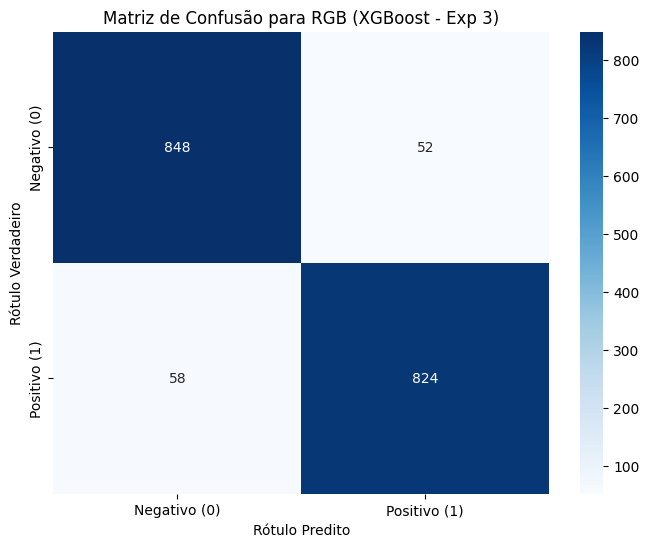

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import numpy as np

# Get the best color mode and features from Experiment 3 results
best_exp3_color = best_exp3_result['Esquema']
selected_features_exp3 = best_features_per_color[best_exp3_color]

print(f"Generating confusion matrix for {best_exp3_color} with XGBoost and I-RFE selected features.")

# Filter df_unified for the best color mode
df_best_color = df_unified[df_unified['color_mode'] == best_exp3_color].copy()

# Prepare data (X, y)
X = df_best_color[selected_features_exp3]
y = df_best_color['label'].values

# Handle cases where all selected features might be constant after filtering
non_constant_features_X = X.columns[X.nunique() > 1]
if non_constant_features_X.empty:
    print(f"All selected features are constant for color mode '{best_exp3_color}'. Cannot generate confusion matrix.")
else:
    X = X[non_constant_features_X]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize XGBoost model and Stratified K-Fold
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Lists to store true and predicted labels across all folds
    y_true_all = []
    y_pred_all = []

    # Perform cross-validation to get predictions for confusion matrix
    for train_index, test_index in kfold.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Negativo (0)', 'Positivo (1)'],
                yticklabels=['Negativo (0)', 'Positivo (1)'])
    plt.title(f'Matriz de Confusão para {best_exp3_color} (XGBoost - Exp 3)')
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Predito')
    plt.show()

In [ ]:
display(summary_df.loc[['Experiment 3 (Unified - All Colors, Best Model, I-RFE Feats)']])

,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC
"Experiment 3 (Unified - All Colors, Best Model, I-RFE Feats)",RGB,XGB,93.83 ± 1.28,94.22 ± 0.97,93.43 ± 2.11,94.07 ± 0.98,93.73 ± 1.34,87.65 ± 2.56,98.53 ± 0.45


Generating SHAP plots for RGB with XGBoost and I-RFE selected features.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:01:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Calculating SHAP values... This may take a while.


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values calculated.
Generating SHAP summary plot (scatter)...


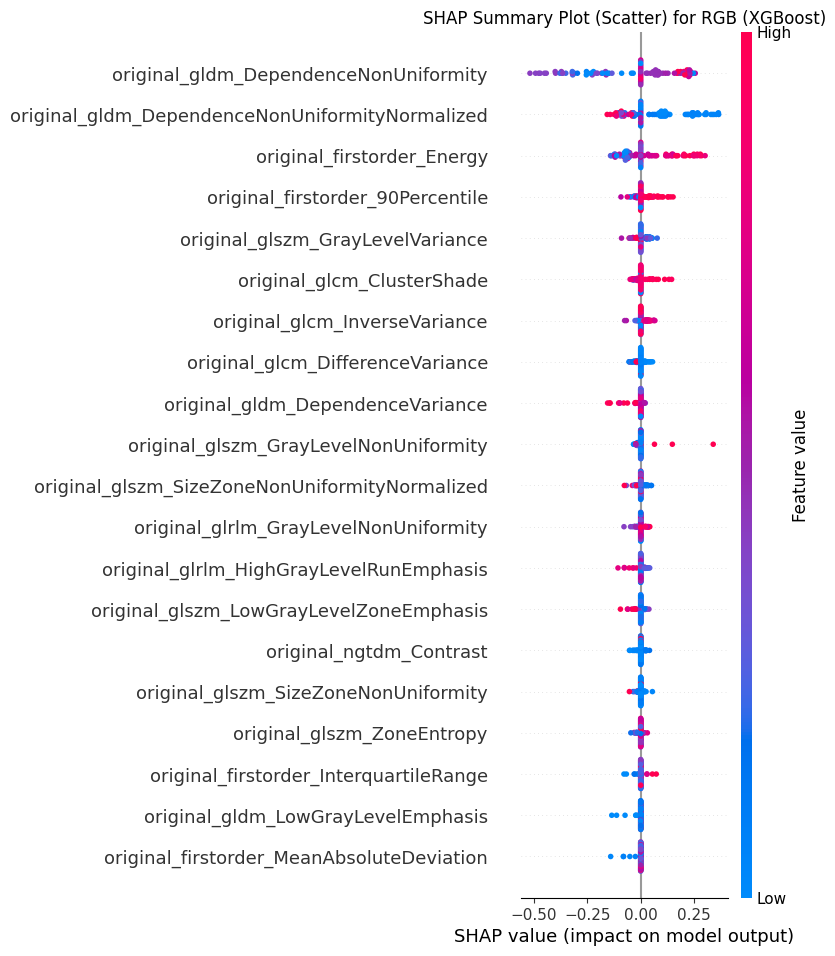

Generating SHAP summary plot (bar)...


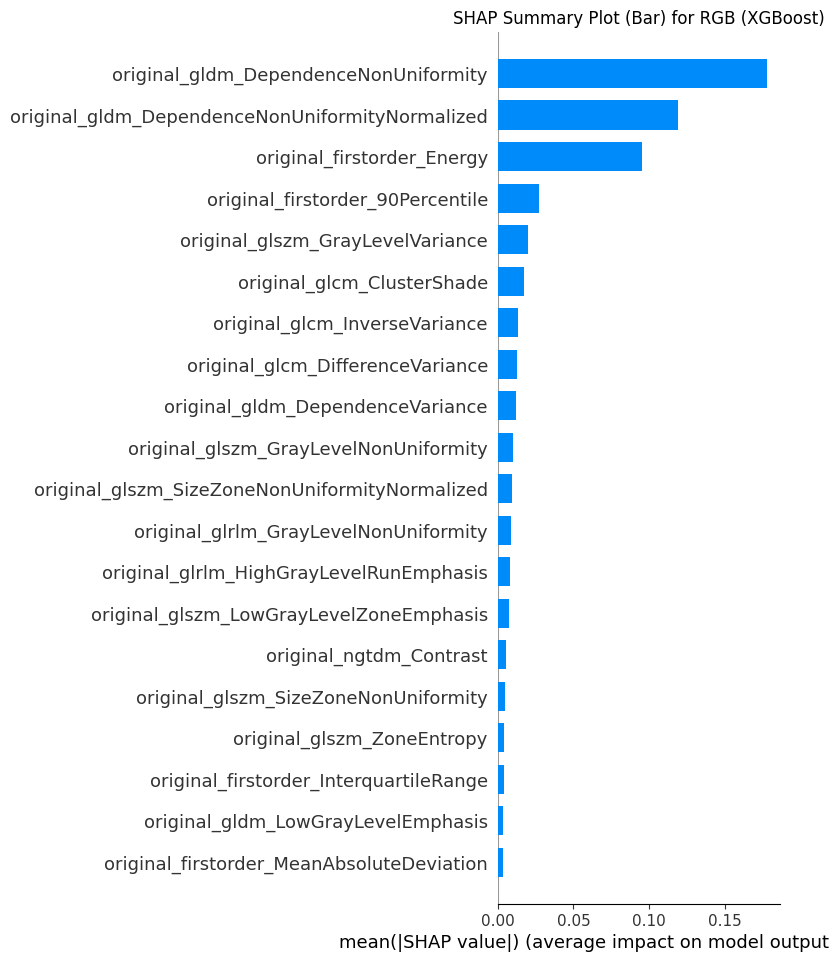

In [ ]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Retrieve best_exp3_color and selected_features_exp3
best_exp3_color = best_exp3_result['Esquema']
selected_features_exp3 = best_features_per_color[best_exp3_color]

print(f"Generating SHAP plots for {best_exp3_color} with XGBoost and I-RFE selected features.")

# 3. Filter df_unified for the best color mode
df_best_color = df_unified[df_unified['color_mode'] == best_exp3_color].copy()

# 4. Prepare data (X, y)
X = df_best_color[selected_features_exp3]
y = df_best_color['label'].values

# Handle cases where all selected features might be constant after filtering
non_constant_features_X = X.columns[X.nunique() > 1]
if non_constant_features_X.empty:
    print(f"All selected features are constant for color mode '{best_exp3_color}'. Cannot generate SHAP plots.")
else:
    X = X[non_constant_features_X]

    # 5. Scale X using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert X_scaled back to DataFrame with feature names for SHAP
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # 6. Split X_scaled and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
    )

    # 7. Initialize and train an XGBClassifier model
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(X_train, y_train)

    # 8. Define a function predict_class_proba
    def predict_class_proba(X_input):
        # Ensure input is a DataFrame for the model
        if isinstance(X_input, np.ndarray):
            X_input = pd.DataFrame(X_input, columns=X_train.columns) # Assuming column order is preserved
        return model.predict_proba(X_input)[:, 1]

    # 9. Create a background dataset for SHAP
    # Take a random sample to reduce computation time
    if X_train.shape[0] > 100:
        X_train_sample = X_train.sample(n=100, random_state=42)
    else:
        X_train_sample = X_train

    kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
    kmeans.fit(X_train_sample)
    background_kmeans = kmeans.cluster_centers_

    # 10. Initialize shap.KernelExplainer
    explainer = shap.KernelExplainer(predict_class_proba, background_kmeans)

    # 11. Calculate SHAP values for X_test
    # For efficiency, sample a subset of X_test if it's very large
    if X_test.shape[0] > 100:
        X_test_sample = X_test.sample(n=100, random_state=42)
    else:
        X_test_sample = X_test

    print("Calculating SHAP values... This may take a while.")
    shap_values = explainer.shap_values(X_test_sample)
    print("SHAP values calculated.")

    # 12. Generate and display the SHAP summary plot (scatter)
    print("Generating SHAP summary plot (scatter)...")
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title(f'SHAP Summary Plot (Scatter) for {best_exp3_color} (XGBoost)')
    plt.show()

    # 13. Generate and display the SHAP bar plot
    print("Generating SHAP summary plot (bar)...")
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot (Bar) for {best_exp3_color} (XGBoost)')
    plt.show()

In [50]:
#Comparação dos melhores valores da replicação vs a melhoria
import pandas as pd
from IPython.display import display

# Dados dos experimentos
data = {
    "Experiment": [
        "Experiment 1 (Original - RGB)",
        "Experiment 1 (Expansed - RGB",
        "Experiment 2 (Original - All Colors, Best Model)",
        "Experiment 2 (Expansed - All Colors, Best Model)",
        "Experiment 3 (Original - All Colors, Best Model, I-RFE)",
        "Experiment 3 (Expansed - All Colors, Best Model, I-RFE)"
    ],
   "Esquema":   ["RGB", "RGB", "XYZ", "RGB", "RGB", "RGB"],
  "Classificador": ["XGB", "XGB", "XGB", "XGB", "XGB", "XGB"],
  "ACC":       ["93.77 ± 1.58", "93.49 ± 0.62", "94.11 ± 1.59", "93.49 ± 0.62", "94.78 ± 0.33", "93.83 ± 1.28"],
  "ESP":       ["93.67 ± 1.25", "93.00 ± 0.83", "92.67 ± 1.70", "93.00 ± 0.83", "93.67 ± 2.21", "94.22 ± 0.97"],
  "SEN":       ["93.86 ± 3.53", "93.99 ± 0.85", "95.58 ± 1.72", "93.99 ± 0.85", "95.91 ± 2.76", "93.43 ± 2.11"],
  "PRE":       ["93.58 ± 1.10", "92.94 ± 0.78", "92.75 ± 1.62", "92.94 ± 0.78", "93.78 ± 1.87", "94.07 ± 0.98"],
  "F1-Score":  ["93.68 ± 1.73", "93.46 ± 0.62", "94.14 ± 1.57", "93.46 ± 0.62", "94.78 ± 0.45", "93.73 ± 1.34"],
  "Kappa":     ["87.53 ± 3.16", "86.98 ± 1.25", "88.22 ± 3.18", "86.98 ± 1.25", "89.56 ± 0.67", "87.65 ± 2.56"],
  "AUC":       ["98.66 ± 0.67", "98.51 ± 0.51", "98.31 ± 1.00", "98.51 ± 0.51", "98.87 ± 0.53", "98.53 ± 0.45"]
}

# Criar DataFrame
df = pd.DataFrame(data)

# Exibir tabela
display(df)

,Experiment,Esquema,Classificador,ACC,ESP,SEN,PRE,F1-Score,Kappa,AUC
0,Experiment 1 (Original - RGB),RGB,XGB,93.77 ± 1.58,93.67 ± 1.25,93.86 ± 3.53,93.58 ± 1.10,93.68 ± 1.73,87.53 ± 3.16,98.66 ± 0.67
1,Experiment 1 (Expansed - RGB,RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51
2,"Experiment 2 (Original - All Colors, Best Model)",XYZ,XGB,94.11 ± 1.59,92.67 ± 1.70,95.58 ± 1.72,92.75 ± 1.62,94.14 ± 1.57,88.22 ± 3.18,98.31 ± 1.00
3,"Experiment 2 (Expansed - All Colors, Best Model)",RGB,XGB,93.49 ± 0.62,93.00 ± 0.83,93.99 ± 0.85,92.94 ± 0.78,93.46 ± 0.62,86.98 ± 1.25,98.51 ± 0.51
4,"Experiment 3 (Original - All Colors, Best Mode...",RGB,XGB,94.78 ± 0.33,93.67 ± 2.21,95.91 ± 2.76,93.78 ± 1.87,94.78 ± 0.45,89.56 ± 0.67,98.87 ± 0.53
5,"Experiment 3 (Expansed - All Colors, Best Mode...",RGB,XGB,93.83 ± 1.28,94.22 ± 0.97,93.43 ± 2.11,94.07 ± 0.98,93.73 ± 1.34,87.65 ± 2.56,98.53 ± 0.45
